# Bayesian Blocks for Broad Excesses (formal)

The goal of the Bayesian Blocks (BB) binning algorithm (http://arxiv.org/abs/1207.5578) is to choose optimal bin edges for a given histogram.  The optimality criterion is expressed by choosing bin edges such that the content within the bin edges is consistent with a uniform distribution, and thus any fluctuation in data values within two given bin edges is solely statistical in nature.  This binning method was initially developed for the astronomy community, in which signals appear as a uniform distribution on top of a noisy, constant background.  If the signal is statistically significant with respect to the background, then it should fall into its own bin in order to maximize a fitness metric, which is a function of the data and the binning.


## A Black Hole Simulation

We have simulated data, and a functional form used to describe that data.

First, we will set up the necessary imports and function definitions:

In [1]:
from __future__ import division
import os
import functools
import numpy as np
import matplotlib.pyplot as plt
import cPickle as pkl
from bb.tools.hist_tools_modified import hist
from bb.tools.bb_plotter import make_fit_plot, make_bb_plot
import bh_comp as bh_tools
import nllfitter.future_fitter as ff

%matplotlib inline
plt.rcParams['figure.figsize'] = (12,8)

Welcome to JupyROOT 6.08/02


We will now load the Monte Carlo data, and specify the background and signal ranges.  We want the range of the BG to be 2800 to 13000 GeV.

In [4]:
bb_dir  = os.path.join(os.path.dirname(bh_tools.__file__), '../..')
df_data_mul2 = pkl.load(open(bb_dir+'/files/BH/BH_test_data.p','rb'))
data_bg_mul2 = df_data_mul2[df_data_mul2.ST_mul2_BB>=2800].ST_mul2_BB.values

df_data_mul8 = pkl.load(open(bb_dir+'/files/BH/BH_paper_data.p','rb'))
data_bg_mul8 = df_data_mul8[df_data_mul8.ST_mul8_BB>=2800].ST_mul8_BB.values

xlimits = (2800, 13000)
x       = np.linspace(xlimits[0], xlimits[1], 10000)
nbins   = 102 # for 10 GeV histogram binning
binning = (xlimits[1]-xlimits[0])/nbins

The background function will be fit with a 3rd order Legendre polynomial, and the signal will be fit with a Gaussian distribution.  These functional forms will be used to generate background and signal MC, which will then be evaluated with the BB algorithm.  This is done to allow for an easy comparison of statistical significance between the BB and unbinned fit methods without the introduction of additional uncertainty regarding the true underlying pdfs.

(0.1, 100000.0)

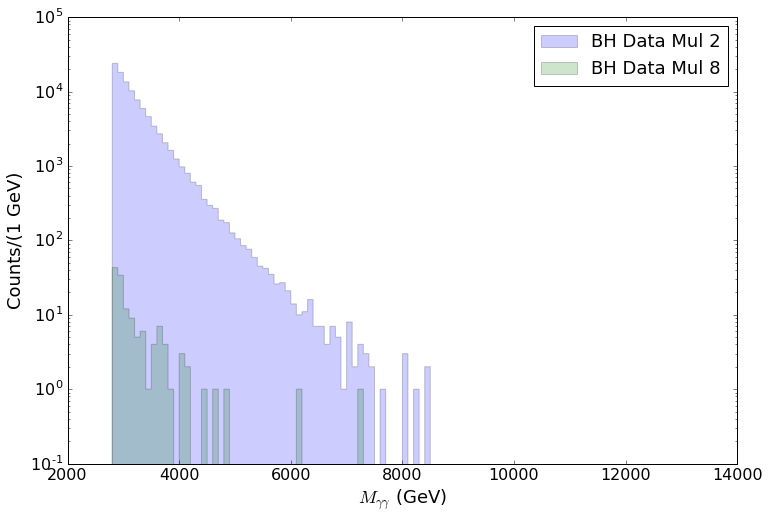

In [52]:
ax = plt.subplot()
ax.hist(data_bg_mul2, bins = 102, stacked=True, alpha=0.2, histtype='stepfilled', label='BH Data Mul 2', range=xlimits)
ax.hist(data_bg_mul8, bins = 102, stacked=True, alpha=0.2, histtype='stepfilled', label='BH Data Mul 8', range=xlimits)
plt.legend()
plt.ylabel('Counts/(1 GeV)')
plt.xlabel('$M_{\gamma\gamma}$ (GeV)')
ax.set_yscale("log", nonposy='clip')
ax.set_ylim(ymin=0.1)

(1e-05, 100000.0)

Performing fit with initial parameters:
alpha	= -18.081
beta	= -0.082
gamma	= 0.806
Fit finished with status: 0
Calculating covariance of parameters...


RESULTS
-------
alpha	= 6.720 +/- 7071.647
beta	= -13.257 +/- 7055.043
gamma	= 1.785 +/- 0.901


CORRELATION MATRIX
------------------
[[ 1.    1.    0.99]
 [ 1.    1.    0.99]
 [ 0.99  0.99  1.  ]]




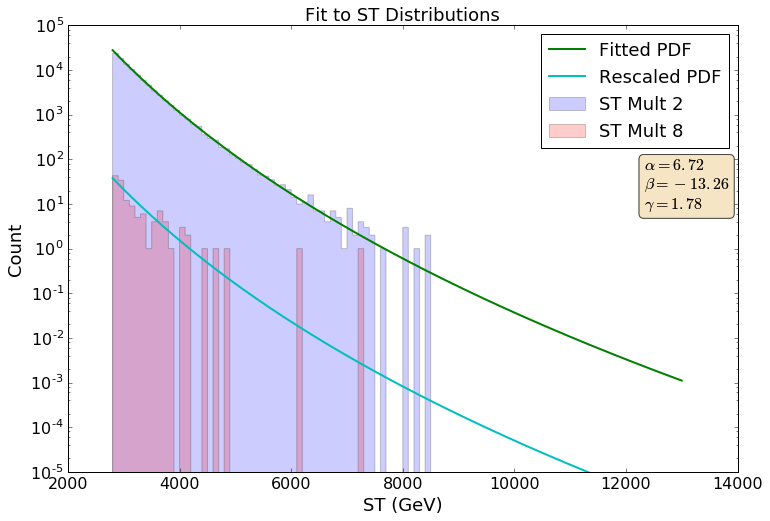

In [75]:
bg_model = ff.Model(bh_tools.bg_pdf, ['alpha', 'beta', 'gamma'])
bg_model.set_bounds([(-200, 200), (-100, 100), (-100,100)])
#bg_model.set_bounds([(-200, 200), (-100,100)])
bg_fitter = ff.NLLFitter(bg_model, data_bg_mul2, min_algo='SLSQP')
bg_result = bg_fitter.fit([-1.80808e+01, -8.21174e-02, 8.06289e-01])
#bg_result = bg_fitter.fit([-1.80808e+01, 8.06289e-01])

textstr = (r'$\alpha={0:.2f}$''\n'r'$\beta={1:.2f}$''\n'r'$\gamma={2:.2f}$').format(*bg_result.x)
#textstr = ('$a_1={0:.2f}$\n$a_2={1:.2f}$').format(*bg_result.x)
ax = make_fit_plot(data_bg_mul2, 102, (2800, 13000), functools.partial(bh_tools.bg_pdf, a=bg_result.x),
        'Fit to ST Distributions', textstr = textstr, hist_label='ST Mult 2', pdf_label='Fitted PDF')
ax = make_fit_plot(data_bg_mul8, 102, (2800, 13000), functools.partial(bh_tools.bg_pdf, a=bg_result.x),
        'Fit to ST Distributions', textstr = textstr, ax=ax, hist_label='ST Mult 8', pdf_label='Rescaled PDF',
                  xlabel='ST (GeV)')
ax.set_yscale("log", nonposy='clip')
ax.set_ylim(ymin=0.00001)

In [48]:
sig_model = ff.Model(hgg_tools.sig_pdf, ['mu', 'sigma'])
sig_model.set_bounds([(110, 130), (1, 5)])
sig_fitter = ff.NLLFitter(sig_model, data_sig)
sig_result = sig_fitter.fit([120.0, 2])

textstr = ('$\mu={0:.2f}$\n$\sigma={1:.2f}$').format(*sig_result.x)
make_fit_plot(data_sig, 80, xlimits, functools.partial(hgg_tools.sig_pdf, a=sig_result.x),
        'Fit to Delphis Signal', textstr = textstr)

NameError: name 'hgg_tools' is not defined

## Generating MC from PDFs

We will use the functional forms defined above to create MC toys using the ROOT pdf sampling methods.  We are going to generate the same number of background and signal events as defined above, and then combine them together into a single dataset.  We can then fit that dataset with the combined background and signal pdfs, and extract a p-value and Gaussian Z-score based on the profile likelihood ratio.

In [63]:
from ROOT import gRandom
from ROOT import TF1

gRandom.SetSeed(111)

# Set up bg sampling
bg_pdf_ROOT = functools.partial(bh_tools.bg_pdf, doROOT=True)
tf1_bg_pdf = TF1("tf1_bg_pdf", bg_pdf_ROOT, 2800, 13000, 3)
tf1_bg_pdf.SetParameters(*bg_result.x)
mc_bg = [tf1_bg_pdf.GetRandom() for i in xrange(len(data_bg_mul8))]

# Set up signal sampling
sig_pdf_ROOT = functools.partial(bh_tools.sig_pdf, doROOT=True)
tf1_sig_pdf = TF1("tf1_sig_pdf", sig_pdf_ROOT, 2800, 13000, 2)
tf1_sig_pdf.SetParameters(5000, 1000)
mc_sig = [tf1_sig_pdf.GetRandom() for i in xrange(20)]

print 'number of bg events:',len(mc_bg)
print 'number of sig events:', len(mc_sig)

mc_bg_sig = mc_bg+mc_sig

number of bg events: 136
number of sig events: 20


(1e-05, 10000.0)

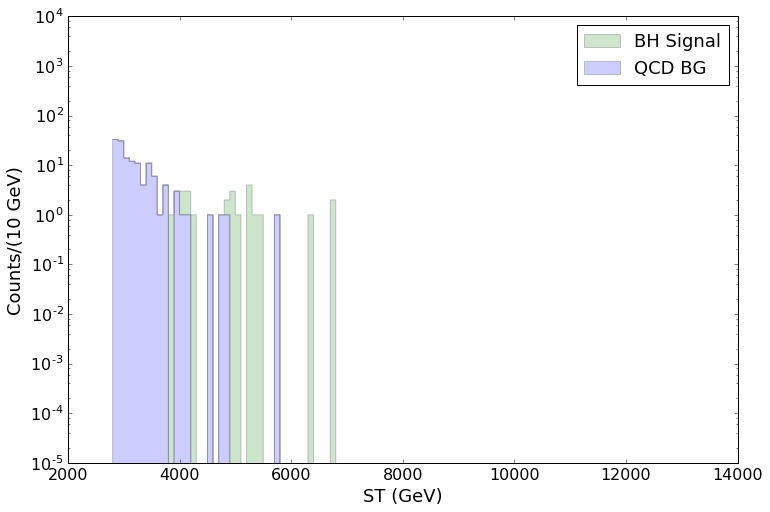

In [64]:
ax = plt.subplot()
plt.hist([mc_bg, mc_sig], bins = 102, range=xlimits, stacked=True,
         alpha=0.2, histtype='stepfilled', label=['QCD BG', 'BH Signal'])
plt.legend()
plt.ylabel('Counts/(10 GeV)')
plt.xlabel('ST (GeV)')
ax.set_yscale("log", nonposy='clip')
ax.set_ylim(ymin=0.00001)

Now we will fit these distributions with the functional forms used to generate them.  We will fit with a background-only pdf and a background+signal pdf.  The ratio of the likelihood produced by these two methods will be used to calculate the significance.

(1e-05, 100.0)

Performing fit with initial parameters:
alpha	= 6.720
beta	= -13.257
gamma	= 1.785
Fit finished with status: 0
Calculating covariance of parameters...


RESULTS
-------
alpha	= -19.952 +/- 30781.032
beta	= 13.478 +/- 30723.152
gamma	= -1.613 +/- 3.147


CORRELATION MATRIX
------------------
[[ 1.     1.     0.956]
 [ 1.     1.     0.956]
 [ 0.956  0.956  1.   ]]




bh_comp.py:42: RuntimeWarning:

overflow encountered in true_divide

bh_comp.py:42: RuntimeWarning:

overflow encountered in double_scalars



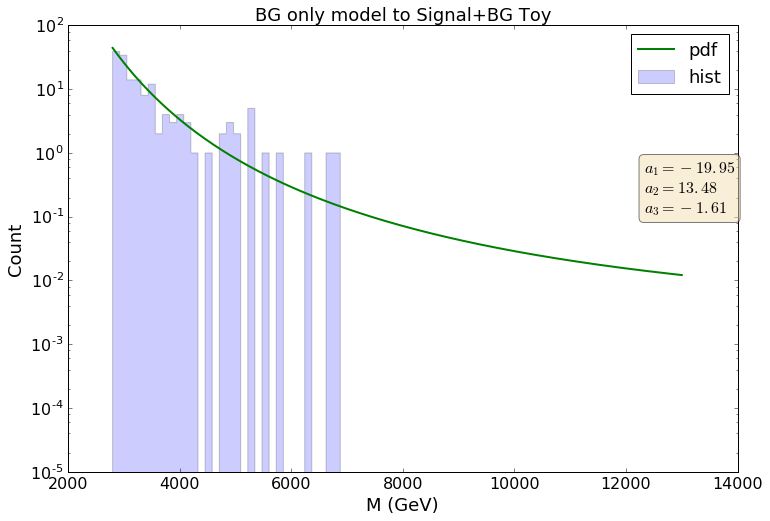

In [65]:
mc_bg_only_fitter = ff.NLLFitter(bg_model, np.asarray(mc_bg_sig))
mc_bg_only_result = mc_bg_only_fitter.fit(bg_result.x)

textstr = ('$a_1={0:.2f}$\n$a_2={1:.2f}$\n$a_3={2:.2f}$').format(*mc_bg_only_result.x)
ax = make_fit_plot(mc_bg_sig, 80, xlimits, functools.partial(bh_tools.bg_pdf, a=mc_bg_only_result.x),
    'BG only model to Signal+BG Toy', textstr = textstr)
ax.set_yscale("log", nonposy='clip')
ax.set_ylim(ymin=0.00001)

(1e-05, 100.0)

Performing fit with initial parameters:
C	= 0.010
mu	= 5000.000
sigma	= 1000.000
alpha	= -20.000
beta	= 0.000
gamma	= 0.000
Fit finished with status: 0
Calculating covariance of parameters...


RESULTS
-------
C	= 0.134 +/- 0.056
mu	= 4997.782 +/- 362.465
sigma	= 870.021 +/- 199.533
alpha	= -1.017 +/- nan
beta	= -18.913 +/- nan
gamma	= 1.677 +/- 6.397


CORRELATION MATRIX
------------------
[[ 1.    -0.63   0.427    nan    nan  0.678]
 [-0.63   1.    -0.588    nan    nan -0.275]
 [ 0.427 -0.588  1.       nan    nan  0.117]
 [   nan    nan    nan    nan    nan    nan]
 [   nan    nan    nan    nan    nan    nan]
 [ 0.678 -0.275  0.117    nan    nan  1.   ]]




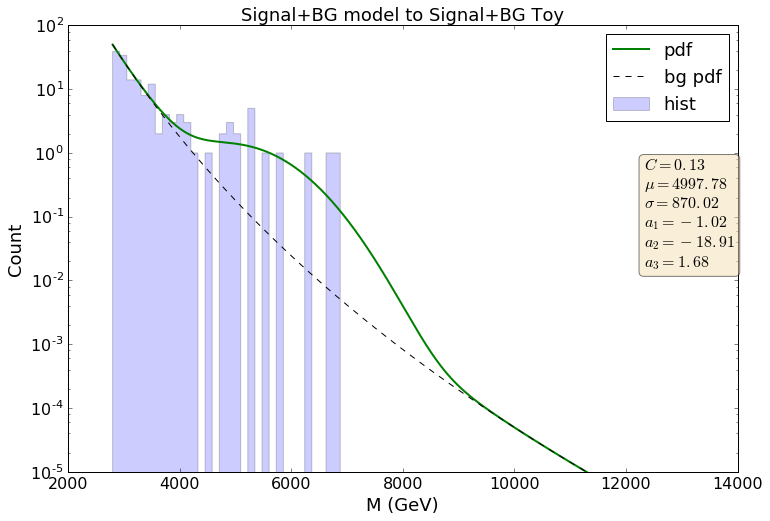

In [66]:
bg_sig_model = ff.Model(bh_tools.bg_sig_pdf, ['C', 'mu', 'sigma', 'alpha', 'beta', 'gamma'])
bg_sig_model.set_bounds([(0, 1), (4000, 10000), (50, 1500), (-200, 200), (-100, 100), (-100,100)])
mc_bg_sig_fitter = ff.NLLFitter(bg_sig_model, np.asarray(mc_bg_sig))
mc_bg_sig_result = mc_bg_sig_fitter.fit([0.01, 5000, 1000, -20.0, 0.0, 0.0])

textstr = ('$C={0:.2f}$\n$\mu={1:.2f}$\n$\sigma={2:.2f}$\n'
          '$a_1={3:.2f}$\n$a_2={4:.2f}$\n$a_3={5:.2f}$').format(*mc_bg_sig_result.x)
ax = make_fit_plot(mc_bg_sig, 80, xlimits, functools.partial(bh_tools.bg_sig_pdf, a=mc_bg_sig_result.x),
    'Signal+BG model to Signal+BG Toy', extra_pdf_tuple=(functools.partial(bh_tools.bg_sig_pdf,
    a=np.concatenate([[0], mc_bg_sig_result.x[1:]])), 1-mc_bg_sig_result.x[0], 'bg pdf'), textstr = textstr)
ax.set_yscale("log", nonposy='clip')
ax.set_ylim(ymin=0.00001)


Now that we have fit the distribution with both a bg-only and a bg+signal pdf, we can compare the two likelihoods in the following way:
$$\lambda(\mu)=\frac{L(\mu,\hat{\hat{\boldsymbol{\theta}}})}{L(\hat{\mu},\hat{\boldsymbol{\theta}})}$$
where $\mu=0$ (representing the background-only hypothesis), and $\hat{\mu}$ is a free parameter, determined by the fitting procedure.  We can then use then construct the test statistic $q_0$ for discovering a new signal:
$$q_0 = \left\{ \begin{array}{ll} -2\ln\lambda(0) & \quad \hat{\mu} \geq 0, \\ 0 & \quad \hat{\mu} <0 \end{array} \right.$$
Assuming the Wald approximation holds (https://arxiv.org/abs/1007.1727), the pdf of $q_0$ for a given $\mu$ can be represented by a $\frac{1}{2}\chi^2$ distribution of 1 degree of freedom, and the CDF of that distribution is:
$$F(q_0|\mu=0)=\Phi(\sqrt{q_0})$$
The Guassian significance is:
$$Z_0 = \sqrt{q_0} $$

In [67]:
from IPython.display import HTML
nll_bg  = mc_bg_only_result.fun
nll_sig = mc_bg_sig_result.fun
q0= 2*max(nll_bg-nll_sig,0)
HTML('<h3><b>Significance of peak from nll fit: {0:.3f} sigma</b></h3>'.format(np.sqrt(q0)))

## Using Bayesian Blocks Binning to Discover Signals

Looking at the plots above, it is not obvious by eye that there is signal injected into the distribution.  We will attempt to use BB binning to both:
  1. Assist in visualizing important data features.
  2. Extract statistical information from the data, using only the histogram content.
  
In order to do so, we will first construct a series of bin edges that represent both the background and the data.

(1e-05, 0.10000000000000001)

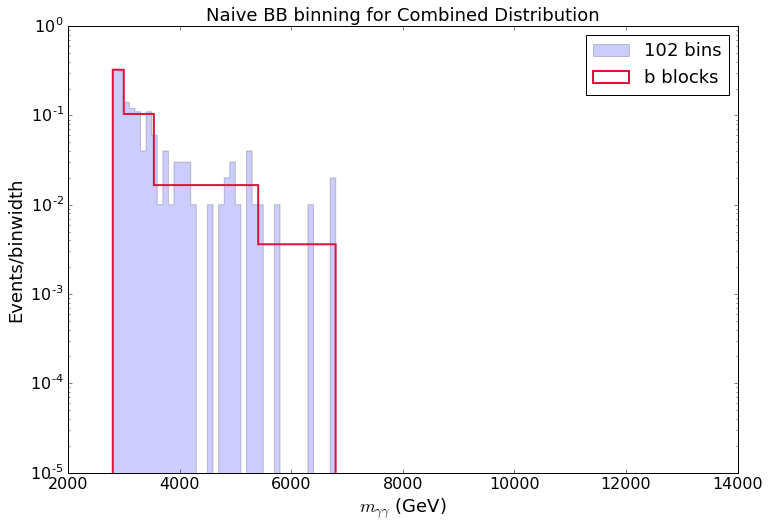

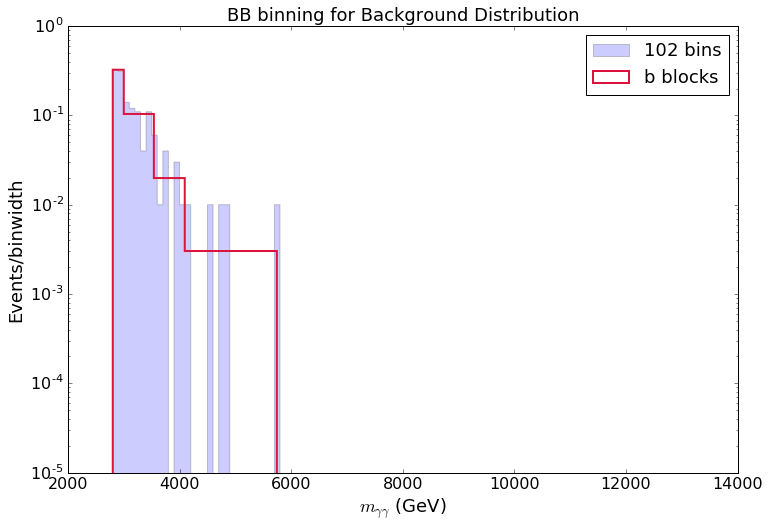

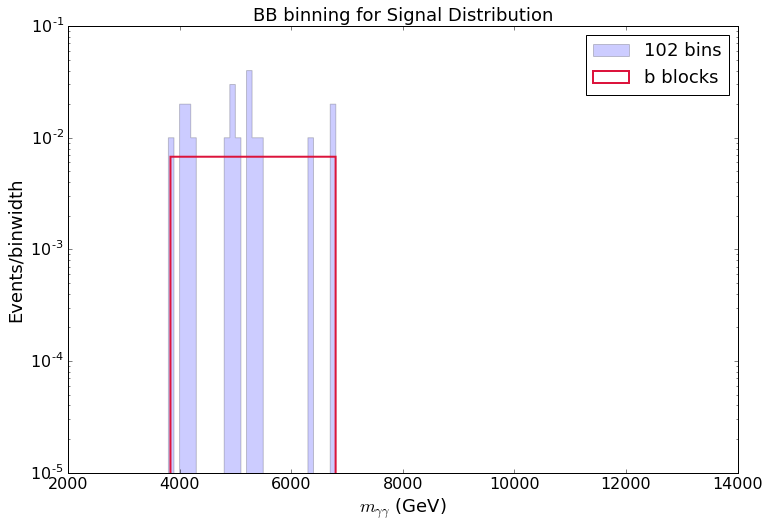

In [73]:
import warnings
warnings.filterwarnings("ignore")

_, _ = make_bb_plot(mc_bg_sig, 0.02, bb_dir+'/plots/', range=xlimits, scale='binwidth',
                title='Naive BB binning for Combined Distribution',
               xlabel=r'$m_{\gamma\gamma}$ (GeV)', ylabel='Events/binwidth', save_name='hgg_bg_hist', bins=102)
ax = plt.gca()
ax.set_yscale("log", nonposy='clip')
ax.set_ylim(ymin=0.00001)
bc_bg, be_bg = make_bb_plot(mc_bg, 0.02, bb_dir+'/plots/', range=xlimits, scale='binwidth',
                title='BB binning for Background Distribution',
               xlabel=r'$m_{\gamma\gamma}$ (GeV)', ylabel='Events/binwidth', save_name='hgg_bg_hist', bins=102)
ax = plt.gca()
ax.set_yscale("log", nonposy='clip')
ax.set_ylim(ymin=0.00001)
bc_sig, be_sig = make_bb_plot(mc_sig, 0.02, bb_dir+'/plots/', range=xlimits, scale='binwidth',
                title='BB binning for Signal Distribution',
                 xlabel=r'$m_{\gamma\gamma}$ (GeV)', ylabel='Events/binwidth', save_name='hgg_sig_hist', bins=102)
ax = plt.gca()
ax.set_yscale("log", nonposy='clip')
ax.set_ylim(ymin=0.00001)


## Running Many Toys

In the following comparison, we will repeat the previous studies for many toys, then compare the average significance for both the nll fit and bayesian block methods.

In [ ]:
%run hgg_comp.py

In [ ]:
binned_model.components

In [ ]:
_,_,pt = hist(signif_bb_true_hist,20, range=(0,10), alpha=0.2, histtype='stepfilled', label='bb true')
_,_,ps = hist(signif_bb_shape_hist,20, range=(0,10), alpha=0.2, histtype='stepfilled', label='bb shape')
hist(signif_nll_true_hist,20, linewidth=2, range=(0,10), histtype='step',color=pt[0].get_facecolor()[:-1], label='nll true')
hist(signif_nll_fit_hist,20, range=(0,10), linewidth=2, histtype='step', color=ps[0].get_facecolor()[:-1], label='nll fit')
hist(signif_nll_constrained_hist,20, range=(0,10), linewidth=2, histtype='step', label='nll constrained')
hist(signif_nll_true_fit_hist,20, range=(0,10), linewidth=2, color='k', histtype='step', label='nll shape')


plt.title('Gaussian Z-score, 500 Toys, Unbinned vs. BB')
plt.xlabel('Z Score')
plt.ylabel('# of toys')
le = plt.legend(loc=1)
plt.gca().add_artist(le)
handles, labels = plt.gca().get_legend_handles_labels()
labels = []
labels.append('mean = {0:.2f}\nmedian = {1:.2f}'.format(np.mean(signif_bb_true_hist),np.median(signif_bb_true_hist)))
labels.append('mean = {0:.2f}\nmedian = {1:.2f}'.format(np.mean(signif_bb_shape_hist),np.median(signif_bb_shape_hist)))
labels.append('mean = {0:.2f}\nmedian = {1:.2f}'.format(np.mean(signif_nll_true_hist),np.median(signif_nll_true_hist)))
labels.append('mean = {0:.2f}\nmedian = {1:.2f}'.format(np.mean(signif_nll_fit_hist),np.median(signif_nll_fit_hist)))
labels.append('mean = {0:.2f}\nmedian = {1:.2f}'.format(np.mean(signif_nll_constrained_hist),np.median(signif_nll_constrained_hist)))
labels.append('mean = {0:.2f}\nmedian = {1:.2f}'.format(np.mean(signif_nll_true_fit_hist),np.median(signif_nll_true_fit_hist)))



plt.legend(handles,labels,loc=2)

In [ ]:
_,_,ps = hist(signif_bb_shape_hist,20, range=(0,10), alpha=0.2, histtype='stepfilled', label='BB Hybrid')
hist(signif_nll_true_fit_hist,20, range=(0,10), linewidth=2, histtype='step', label='NLL (constrained)')


plt.title('Gaussian Z-score, 500 Toys, Unbinned vs. BB')
plt.xlabel('Z Score')
plt.ylabel('# of toys')
le = plt.legend(loc=1)
plt.gca().add_artist(le)
handles, labels = plt.gca().get_legend_handles_labels()
labels = []
labels.append('mean = {0:.2f}\nmedian = {1:.2f}'.format(np.mean(signif_bb_shape_hist),np.median(signif_bb_shape_hist)))
labels.append('mean = {0:.2f}\nmedian = {1:.2f}'.format(np.mean(signif_nll_constrained_hist),np.median(signif_nll_constrained_hist)))



plt.legend(handles,labels,loc=2)

In [ ]:
hist(signif_bb_true_hist,20, range=(0,10), alpha=0.2, histtype='stepfilled', label='bb')
hist(signif_1GeV_true_hist,20, range=(0,10), linewidth=2, histtype='step', label='1 GeV')
hist(signif_2GeV_true_hist,20, range=(0,10), linewidth=2, histtype='step', label='2 GeV')
hist(signif_5GeV_true_hist,20, range=(0,10), linewidth=2, histtype='step', label='5 GeV')
hist(signif_10GeV_true_hist,20, range=(0,10), linewidth=2, histtype='step', label='10 GeV')
plt.title('Gaussian Z-score, 500 Toys, Various Bin Widths')
plt.xlabel('Significance')
plt.ylabel('# of toys')
plt.legend()

In [ ]:
be_hybrid = np.concatenate([be_bg[be_bg<be_sig[0]], be_sig, be_bg[be_bg>be_sig[-1]]])
bc_bg, _, _ = hist(mc_bg,be_hybrid,alpha=0.2,scale='binwidth', label='bg only')
bc_bg_sig, _, _ = hist(mc_bg_sig,be_hybrid,scale='binwidth', histtype='step', linewidth = 2, label='bg+signal')
plt.title('Hybrid binning on bg only and bg+signal')
plt.xlabel('Mgg')
plt.ylabel('Events/bin width')
plt.legend()
plt.show()